<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Part 2: Preprocessing, EDA and Model Building

## Problem Statement

Using Pushshift's API, posts from two subreddits, namely r/depression and r/BipolarReddit, will be collected. I will then use NLP to train a classifier to determine which subreddit a given post came from.

### Contents:
- [Import data](#Import-data)
- [Data cleaning](#Data-cleaning)
- [Preprocessing and EDA](#Preprocessing-and-EDA)
- [Models Building](#Models-Building)
- [Model Selection](#Model-Selection)
- [Results Analysis and Conclusion](#Results-Analysis-and-Conclusion)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import time
import random
import regex as re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import metrics.
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.inspection import permutation_importance

## Import data

In [13]:
df_depress=pd.read_csv('../data/depression_posts.csv')
df_bipolar=pd.read_csv('../data/bipolar_posts.csv')

## Data cleaning

In [14]:
# Display columns of Depress Dataframe
df_depress.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'suggested_sort', 'thumbnail', 'title',


In [15]:
# Display columns of Bipolar Dataframe
df_bipolar.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subre

In [16]:
# Check column names of one subreddit against the other and returns those present in one but not the other
print('Columns which are unique to Depression Subreddit:')  
for x in df_depress.columns.tolist():
    if x not in df_bipolar.columns.tolist():
        print(x)

print('\n')

print('Columns which are unique to Bipolar Subreddit:')
for x in df_bipolar.columns.tolist():
    if x not in df_depress.columns.tolist():
        print(x)

Columns which are unique to Depression Subreddit:
suggested_sort
call_to_action
category
banned_by


Columns which are unique to Bipolar Subreddit:
link_flair_template_id
link_flair_text
author_flair_template_id
crosspost_parent
crosspost_parent_list
url_overridden_by_dest


It seems that the columns which are present in only one of the dataframes are not very useful in providing us information to identify which subreddit they belong to. After looking at the columns of both dataframes, these stood out as the most important columns:


|Column Name|Description|
|-----------|-----------|
|selftext|The body of the post|
|title|Title of the post|
|subreddit|Identifies which subreddit post was from|


In [17]:
# Storing our selected columns in a list
cols = ['selftext','title','subreddit']

In [18]:
# Updating dataframes with only selected columns displayed
df_depress = df_depress[cols]
df_bipolar = df_bipolar[cols]

In [19]:
# Checks for duplicate values in 'selftext','title' columns for df_depress and returns the shape
df_depress[df_depress.duplicated(subset=['selftext','title'])].shape

(14, 3)

In [20]:
# Checks for duplicate values in 'selftext','title' columns for df_bipolar and returns the shape
df_bipolar[df_bipolar.duplicated(subset=['selftext','title'])].shape

(5, 3)

As both subreddits have a few duplicates (14 for Depression, 5 for Bipolar), I will be dropping them as they constitute a very small percentage of data lost (1.4% for Depression, 0.5% for Bipolar).

In [21]:
# Drop duplicated rows identified in 'selftext', 'title' columns in place
df_depress.drop_duplicates(subset=['selftext','title'],inplace=True)
df_bipolar.drop_duplicates(subset=['selftext','title'],inplace=True)

In [22]:
# Displays information of Depression dataframe
df_depress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   985 non-null    object
 1   title      986 non-null    object
 2   subreddit  986 non-null    object
dtypes: object(3)
memory usage: 30.8+ KB


In [23]:
# Displays information of Bipolar dataframe
df_bipolar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   926 non-null    object
 1   title      995 non-null    object
 2   subreddit  995 non-null    object
dtypes: object(3)
memory usage: 31.1+ KB


In [24]:
# Checks the Depression dataframe for missing values
df_depress.isnull().sum()

selftext     1
title        0
subreddit    0
dtype: int64

In [25]:
# Checks the Bipolar dataframe for missing values
df_bipolar.isnull().sum()

selftext     69
title         0
subreddit     0
dtype: int64

There are null values for 'selftext' in both dataframes. It seems like posts where users only posted a title but no post body. As I will combine both the selftext and title columns later on, I will deal with these null values by assigning them an empty string value(''). The reason for doing this instead of dropping them is because I feel that these titles might provide me with useful information that may aid in identifying which subreddit they belong to.

In [26]:
# Fill 'selftext' null values with empty string
df_depress['selftext'] = df_depress['selftext'].fillna('')
df_bipolar['selftext'] = df_bipolar['selftext'].fillna('')

In [27]:
df_depress.isnull().sum()

selftext     0
title        0
subreddit    0
dtype: int64

In [28]:
df_bipolar.isnull().sum()

selftext     0
title        0
subreddit    0
dtype: int64

In [29]:
# View Depression dataframe
df_depress.head()

,selftext,title,subreddit
0,Random vent honestly because I’d rather post a...,Random vent.,depression
1,"Waking up is too saddening, I stay up until my...",just waking up makes me too sad,depression
2,[removed],28M and a college dropout virgin,depression
3,Something something…I hate my life no one can ...,Going through the motions.,depression
4,[removed],Been all alone since new years TW SA,depression


In [30]:
# View Bipolar dataframe
df_bipolar.head()

,selftext,title,subreddit
0,"It's almost 5 am. I'm not tired at all, I'm st...",self harm help?,BipolarReddit
1,"While not directly related to bipolar, he has ...",Anyone checked out the works of Gabor Maté?,BipolarReddit
2,"After years of mental struggles, I’m getting h...",Is a diagnosis going to limit my life?,BipolarReddit
3,"I give you back the years of judgement,\n\n\nW...",Give you back the shame (Poem),BipolarReddit
4,Context: A few months back I had a manic episo...,Has anyone ever gotten an audio hallucination ...,BipolarReddit


In [31]:
df_depress.describe()

,selftext,title,subreddit
count,986,986,986
unique,753,977,1
top,[removed],I hate myself,depression
freq,232,3,986


In [32]:
df_bipolar.describe()

,selftext,title,subreddit
count,995,995,995
unique,919,985,1
top,,Question,BipolarReddit
freq,69,3,995


### Remove unwanted "[removed]" tags 

There are some "[removed]" string values for 'selftext' in both dataframes which will not provide any useful information, and will be replaced with an empty string value('').

In [33]:
# List rows with [removed] string for Depression dataframe
substring = "\[removed]"
df_depress[df_depress.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]

,selftext,title,subreddit
2,[removed],28M and a college dropout virgin,depression
4,[removed],Been all alone since new years TW SA,depression
13,[removed],I’m broken.,depression
14,[removed],Depression becoming less depressing.,depression
24,[removed],Please spend time with me,depression
...,...,...,...
984,[removed],I don’t know how to speak to people,depression
985,[removed],Memory loss at work + University PLEASE READ,depression
990,[removed],Do you ever give up when you have a bad day at...,depression
997,[removed],Do you ever just wanna scream at the top of yo...,depression


In [34]:
# List rows with [removed] string for Bipolar dataframe
substring = "\[removed]"
df_bipolar[df_bipolar.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]

,selftext,title,subreddit
55,[removed],Insomnia: A Prevalent Menace - Part VIII - A R...,BipolarReddit
120,[removed],"Hypomania at night, really funny to deal with.",BipolarReddit
195,[removed],I need help 😢😢,BipolarReddit
198,[removed],"Seroquel was hell, switched to Geodon, 40mg fo...",BipolarReddit
680,[removed],"This week I was involuntarily hospitalized, lo...",BipolarReddit
696,[removed],Poetry,BipolarReddit
828,[removed],What's wrong with y'all?,BipolarReddit
864,[removed],ayahuasca,BipolarReddit


In [35]:
# Replace [removed] with empty string for Depression dataframe
df_depress['selftext'] = df_depress['selftext'].str.replace(substring, "")

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_90634/75067027.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_depress['selftext'] = df_depress['selftext'].str.replace(substring, "")


In [36]:
df_depress.describe()

,selftext,title,subreddit
count,986,986,986
unique,752,977,1
top,,I hate myself,depression
freq,233,3,986


In [37]:
# Replace [removed] with empty string for Bipolar dataframe
df_bipolar['selftext'] = df_bipolar['selftext'].str.replace(substring, "")

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_90634/66602331.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_bipolar['selftext'] = df_bipolar['selftext'].str.replace(substring, "")


In [38]:
df_bipolar.describe()

,selftext,title,subreddit
count,995,995,995
unique,918,985,1
top,,Question,BipolarReddit
freq,77,3,995


### Concatenate cleaned data to final dataframe

In [39]:
# Concat cleaned Depression and Bipolar posts to final dataframe
final_df = pd.concat([df_depress, df_bipolar])

In [40]:
# Check shape
final_df.shape

(1981, 3)

In [41]:
# Check columns
final_df.columns

Index(['selftext', 'title', 'subreddit'], dtype='object')

In [43]:
# Baseline accuracy
final_df['subreddit'].value_counts(normalize = True)

BipolarReddit    0.502272
depression       0.497728
Name: subreddit, dtype: float64

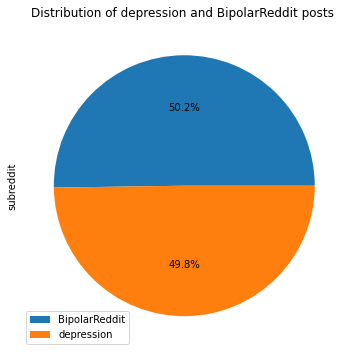

In [44]:
# Plot distribution of posts
final_df['subreddit'].value_counts().plot.pie(figsize=(6,6),title="Distribution of depression and BipolarReddit posts ",labels=['',''],autopct='%1.1f%%')
labels=["BipolarReddit","depression"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Looking at the normalized value counts, our dataset looks balanced with ~ 50.2% of posts belonging to the 'depression' subreddit and ~49.8% of posts belonging to the 'BipolarReddit' subreddit.

### Map and replace Depression category to 0 and Bipolar to 1

In [45]:
# Convert categories 'BipolarReddit' =1 and 'depression'=0
final_df['subreddit'] = final_df['subreddit'].map(dict(BipolarReddit=1, depression=0))
final_df['subreddit'].value_counts()

1    995
0    986
Name: subreddit, dtype: int64

In [46]:
# Baseline score = (No. of cat 1 posts / (No. of cat 0 posts + No. of cat 1 posts))
print(f'Baseline score = {995 / (986 + 995)}')

Baseline score = 0.5022715800100959


In [47]:
# Check types
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   1981 non-null   object
 1   title      1981 non-null   object
 2   subreddit  1981 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 61.9+ KB


In [48]:
final_df.head()

,selftext,title,subreddit
0,Random vent honestly because I’d rather post a...,Random vent.,0
1,"Waking up is too saddening, I stay up until my...",just waking up makes me too sad,0
2,,28M and a college dropout virgin,0
3,Something something…I hate my life no one can ...,Going through the motions.,0
4,,Been all alone since new years TW SA,0


### Comparison of word counts for posts between the subreddits

In [49]:
# Combining the 'selftext' and 'title' columns to facilitate easier processing
final_df['all_text'] = final_df['title'] + " " +  final_df['selftext']

In [50]:
# Creating new columns for lengths of selftext'/'title' using lambda function to count the number of non-whitespace words
final_df['all_text_wordcount'] = final_df['all_text'].apply(lambda x: len(re.findall('\\S+', x)))

# Count the number of characters in the posts
final_df['all_text_len'] = final_df['all_text'].str.len()

# Storing filtered dataframes for each subreddit as variables for easier referencing
sub0_df = final_df[final_df['subreddit']==0] # DF showing posts from depression subreddit
sub1_df = final_df[final_df['subreddit']==1] # DF showing posts from BipolarReddit subreddit

In [51]:
print(sub0_df.all_text_len.median())
print(sub1_df.all_text_len.median())
print(sub0_df.all_text_wordcount.median())
print(sub1_df.all_text_wordcount.median())

468.5
532.0
91.5
99.0


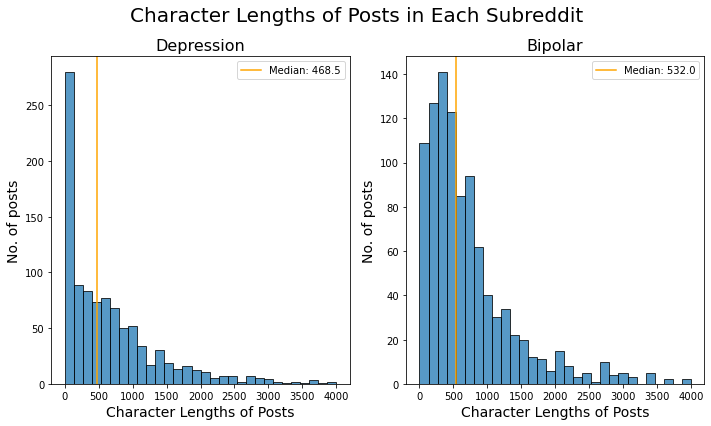

In [52]:
# Histplots of posts length for both subreddits 
fig, ax = plt.subplots(1,2,figsize=(10,6),tight_layout=True,)

plot1 = sns.histplot(sub0_df,x="all_text_len",bins= 30,ax = ax[0],binrange=[0, 4000])
plot2 = sns.histplot(sub1_df,x="all_text_len",bins=30,ax = ax[1],binrange= [0, 4000]);

plot1.axvline(x = sub0_df.all_text_len.median(), color = 'orange', label = 'Median: 468.5')
plot2.axvline(x = sub1_df.all_text_len.median(), color = 'orange', label = 'Median: 532.0')
plot1.legend(loc='upper right')
plot2.legend(loc='upper right')
                 
ax[0].set_xlabel('Character Lengths of Posts', fontsize=14)
ax[1].set_xlabel('Character Lengths of Posts', fontsize=14)

ax[0].set_ylabel('No. of posts', fontsize=14)
ax[1].set_ylabel('No. of posts', fontsize=14)

ax[0].set_title('Depression', fontsize=16)
ax[1].set_title('Bipolar', fontsize=16)

fig.suptitle('Character Lengths of Posts in Each Subreddit', fontsize=20);

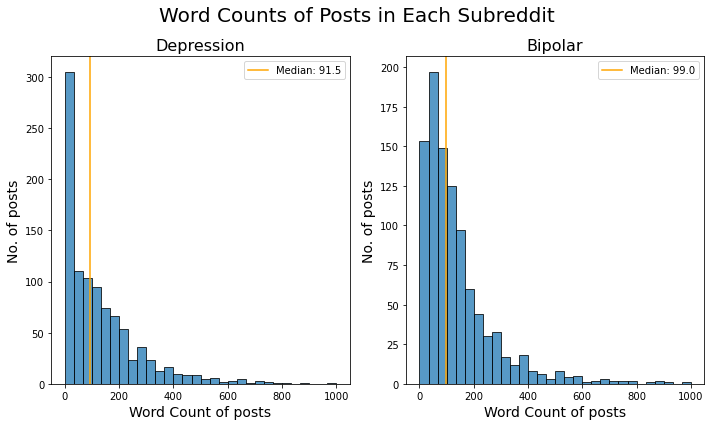

In [53]:
# Histplots of wordcounts for both subreddits 
fig, ax = plt.subplots(1,2,figsize=(10,6),tight_layout=True,)

plot3 = sns.histplot(sub0_df,x="all_text_wordcount",bins=30,ax = ax[0],binrange=[0, 1000])
plot4 = sns.histplot(sub1_df,x="all_text_wordcount",bins=30,ax = ax[1],binrange= [0, 1000]);

plot3.axvline(x = sub0_df.all_text_wordcount.median(), color = 'orange',label='Median: 91.5')
plot4.axvline(x = sub1_df.all_text_wordcount.median(), color = 'orange',label='Median: 99.0')
plot3.legend(loc='upper right')
plot4.legend(loc='upper right')

ax[0].set_xlabel('Word Count of posts', fontsize=14)
ax[1].set_xlabel('Word Count of posts', fontsize=14)

ax[0].set_ylabel('No. of posts', fontsize=14)
ax[1].set_ylabel('No. of posts', fontsize=14)

ax[0].set_title('Depression', fontsize=16)
ax[1].set_title('Bipolar', fontsize=16)

fig.suptitle('Word Counts of Posts in Each Subreddit', fontsize=20);

Based on the plot above, we can see that the distribution for both subreddits are right-skewed. It seems that Bipolar subreddit tend to have higher word counts as well as character lengths with higher medians for both columns as compared to Depression.

## Preprocessing and EDA

### Normalize text with POS Tagger and Lemmatizer

In [54]:
# Function to clean data with POS Tagger and Lemmatizer
def clean(text):
    lemmatizer = WordNetLemmatizer()
    wn = wordnet
    tag_dict = {"J": wn.ADJ,
            "N": wn.NOUN,
            "V": wn.VERB,
            "R": wn.ADV}

    def extract_wnpostag_from_postag(tag):
        return tag_dict.get(tag[0].upper(), None)

    def lemmatize_tupla_word_postag(tupla):
        tag = extract_wnpostag_from_postag(tupla[1])
        return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]
    
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text) # Tokenize text
    lower = [word.lower() for word in tokens] # Change text to lowercase
    no_stopwords = [word for word in lower if word not in stopword] # Remove stopwords
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    tagged_words = nltk.pos_tag(no_alpha) # Return a list of tuples: (word, tagString) like ('And', 'CC')
    lemm_text = [ lemmatize_tupla_word_postag(ow) for ow in tagged_words ]
    clean_text = lemm_text
    return clean_text

Processing data...
Creating word clouds...


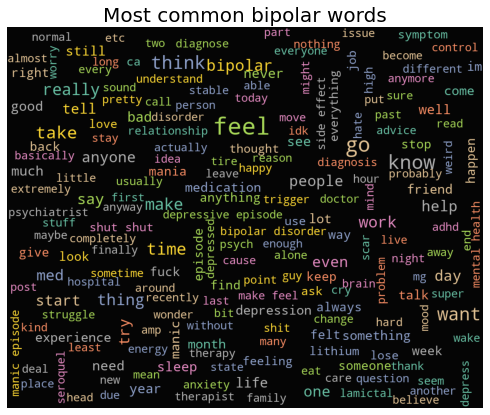

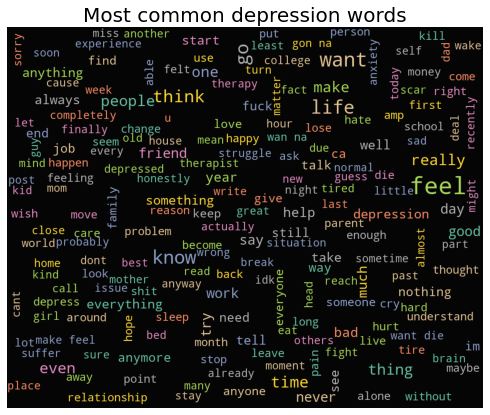

In [60]:
# Function to generate wordcloud
def generate_wordcloud(words,condition):
    plt.figure(figsize=(9,7))
    wc = WordCloud(background_color="black", max_words=200, width = 1000, height = 800, max_font_size=50)
#    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(condition), fontsize=20)
#    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.imshow(wc.recolor(colormap='Set2', random_state=17), alpha=0.98)
    plt.axis('off')
    
#final_df=final_df.head(1000)
print("Processing data...")
final_df['clean']=final_df['all_text'].map(clean)
final_df['clean_text']=final_df['clean'].apply(lambda x: " ".join([str(word) for word in x]))

print("Creating word clouds...")
bipolar_words=" ".join(final_df[final_df.subreddit==1]['clean_text'].values)
depress_words=" ".join(final_df[final_df.subreddit==0]['clean_text'].values)

generate_wordcloud(bipolar_words,"bipolar")
generate_wordcloud(depress_words,"depression")

In [61]:
final_df.head()

,selftext,title,subreddit,all_text,all_text_wordcount,all_text_len,clean,clean_text
0,Random vent honestly because I’d rather post a...,Random vent.,0,Random vent. Random vent honestly because I’d ...,287,1462,"[random, vent, random, vent, honestly, rather,...",random vent random vent honestly rather post a...
1,"Waking up is too saddening, I stay up until my...",just waking up makes me too sad,0,just waking up makes me too sad Waking up is t...,78,376,"[wake, make, sad, wake, sadden, stay, body, fo...",wake make sad wake sadden stay body force slee...
2,,28M and a college dropout virgin,0,28M and a college dropout virgin,6,33,"[college, dropout, virgin]",college dropout virgin
3,Something something…I hate my life no one can ...,Going through the motions.,0,Going through the motions. Something something...,68,344,"[go, motion, something, hate, life, one, chang...",go motion something hate life one change gon n...
4,,Been all alone since new years TW SA,0,Been all alone since new years TW SA,8,37,"[alone, since, new, year, tw, sa]",alone since new year tw sa


In [62]:
final_df.shape

(1981, 8)

### Save final cleaned data to CSV file

In [63]:
# Save final_df to csv file
final_df.to_csv('../data/final_posts.csv',index=False)

### Text Columns

We will now explore the text columns. To do so, we will count-vectorize clean_text to obtain the frequency of word occurence and see if the most frequent words differ between the two subreddits.

### (CountVectorizer) Generating Top 15 most occurring words in posts of both subreddits

In [64]:
# Storing cleaned dataframes for each subreddit as variables for easier referencing
sub0_cleaned = final_df[final_df['subreddit']==0] # DF showing posts from depression subreddit
sub1_cleaned = final_df[final_df['subreddit']==1] # DF showing posts from BipolarReddit subreddit

In [65]:
# Function to list top most occuring words using CountVectorizer
def top_words(sub):
    #Instantiate CountVectorizer
    cvec = CountVectorizer(max_features=1000, stop_words = 'english')
    # Fit and transform the clean_text of the subreddit
    clean_text_cvec = cvec.fit_transform(sub['clean_text'])
    # Put the transformed clean_text into a DataFrame
    clean_text_sub = pd.DataFrame(clean_text_cvec.todense(), columns = cvec.get_feature_names())
    # Show the top 15 words in posts of subreddit
    top_15 = clean_text_sub.sum().sort_values(ascending=False)[:15]
    return top_15

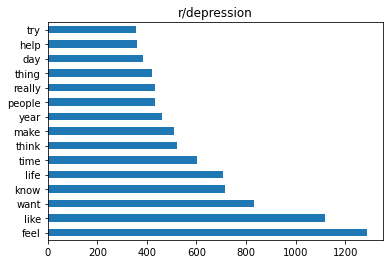

In [134]:
# Plot top most occurring words in depression subreddit
top_words(sub0_cleaned).plot(kind='barh')
plt.title('r/depression', fontsize=12);

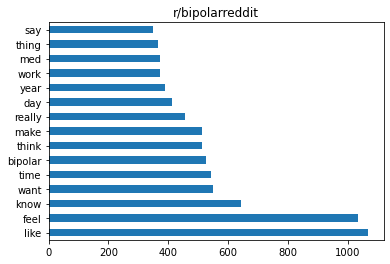

In [135]:
# Plot top most occurring words in bipolar subreddit
top_words(sub1_cleaned).plot(kind='barh')
plt.title('r/bipolarreddit', fontsize=12);

## Models Building

The following models will be built for our classification problem:

1. Random Forest Classifier with CountVectorizer
2. Random Forest Classifier with TfidfVectorizer
3. Multinomial Naive Bayes with CountVectorizer
4. Multinomial Naive Bayes with TfidfVectorizer

In [68]:
# Function to get GridCV scores of Random Forest and Naive Bayes classifiers 
# with Count Vectorizer and Tfidf Vectorizer.
# Inputs:
#   X_train,X_test,y_train,y_test
#   vect= 'CVT' - for Count Vectorizer
#         'TFIDF' - for Tfidf Vectorizer
#   estm= 'RF' - for Random Forest
#         'MNB' - for Naive Bayes
#
def models_func(X, y, params, vect, estm):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)
    
    if vect=='CVT' and estm=='RF': #pipline and GridSearchCV for Random Forest and Count Vectorizer
        model_name='    Random Forest and Count Vectorizer'
        pipe = Pipeline([('vect', CountVectorizer()),('rf', RandomForestClassifier())])
        gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
        
    elif vect=='TFIDF' and estm=='RF': #pipline and GridSearchCV Random Forest and Tfidf Vectorizer
        model_name='    Random Forest and Tfidf Vectorizer'
        pipe = Pipeline([('vect', TfidfVectorizer()),('rf', RandomForestClassifier())])       
        gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
    
    elif vect=='CVT' and estm=='MNB': #pipline and GridSearchCV for Naive Bayes and Count Vectorizer
        model_name='    Naive Bayes and Count Vectorizer'
        pipe = Pipeline([('vect', CountVectorizer()),('nb', MultinomialNB())])
        gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
        
    elif vect=='TFIDF' and estm=='MNB': #pipline and GridSearchCV Naive Bayes and Tfidf Vectorizer
        model_name='    Naive Bayes and Tfidf Vectorizer'
        pipe = Pipeline([('vect', TfidfVectorizer()),('nb', MultinomialNB())])
        gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
        
    print('################################################')
    print('  {}'.format(model_name))
    print('################################################')
    
    # Fit to GridSearchCV
    model = gs.fit(X_train, y_train)

    # Score model on training data
    train_score = gs.score(X_train, y_train)
    
    # Score model on testing data
    test_score  = gs.score(X_test, y_test)
    
    # Get predictions
    preds = gs.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Plot confusion matrix
#    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['depression', 'bipolar']);
    
    # Calculate the sensitivity/ recall
    sensitivity = tp / (tp + fn)
    
    # Calculate the precision
    precision = tp / (tp + fp)
    
    # Calculate the f1 score
    f1 = 2 * (sensitivity * precision)/ (sensitivity + precision)
    
    # Generate a confusion matrix.
    cm = confusion_matrix(y_test, preds)
    cm_df = pd.DataFrame(cm, index=['Actual Depressed', 'Actual Bipolar'], 
                         columns=['Predicted Depressed', 'Predicted Bipolar'])
    
    # Generate classification report
    cr = classification_report(y_test,preds)
    
    # Calculate accuracy
    accu = round(accuracy_score(y_test,preds)*100,2)
    
    # Calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, gs.predict_proba(X_train)[:,1])
    roc_auc_test = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])
    
    # Print results
    print(f'Best parameters: {gs.best_params_}')
    print(f'Train score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score,4)}')
    print(f'Generalisation: {round(abs(100*(train_score - test_score) / train_score),2)}%')
    print(f'Accuracy: {round(accu,4)}%')
    print(f'Sensitivity: {tp / (tp + fn)}')
    print(f'Specificity: {tn / (tn + fp)}')
    print(f'Precision: {tp / (tp + fp)}')
    print(f'F1-score: {round(f1,4)}')
    print(f'Train ROC AUC score: {round(roc_auc_train,4)}')
    print(f'Test ROC AUC score: {round(roc_auc_test,4)}')
    print(cm_df)
    print(cr)

In [69]:
# Setting values for X and y
X = final_df['clean_text']
y = final_df['subreddit']

### `1. Random Forest with CountVectorizer`

In [70]:
# Parameters for Count Vectorizer and Random Forest pipeline
params = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_features': [1_000, 2_000, 3_000],
    'vect__min_df': [2, 3],
    'vect__max_df': [.9, .95],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__min_samples_split': [10, 20, 30],
    'rf__min_samples_leaf':[5, 10, 15],
}

#'CVT' - for Count Vectorizer
#'RF' - for Random Forest
vect='CVT'
estm='RF'
%time models_func(X, y, params, vect, estm)

################################################
      Random Forest and Count Vectorizer
################################################
Best parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 20, 'rf__n_estimators': 200, 'vect__max_df': 0.9, 'vect__max_features': 3000, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}
Train score: 0.8512
Test score: 0.8427
Generalisation: 0.99%
Accuracy: 84.27%
Sensitivity: 0.7309236947791165
Specificity: 0.9554655870445344
Precision: 0.9430051813471503
F1-score: 0.8235
Train ROC AUC score: 0.9266
Test ROC AUC score: 0.9008
                  Predicted Depressed  Predicted Bipolar
Actual Depressed                  236                 11
Actual Bipolar                     67                182
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       247
           1       0.94      0.73      0.82       249

    accuracy                           0.84       496
   macro av

### `2. Random Forest with TfidfVectorizer`

In [72]:
#'TFIDF' - for Tfidf Vectorizer
#'RF' - for Random Forest
vect='TFIDF'
estm='RF'
%time models_func(X, y, params, vect, estm)

################################################
      Random Forest and Tfidf Vectorizer
################################################
Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 30, 'rf__n_estimators': 200, 'vect__max_df': 0.95, 'vect__max_features': 2000, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
Train score: 0.9192
Test score: 0.8548
Generalisation: 7.0%
Accuracy: 85.48%
Sensitivity: 0.7791164658634538
Specificity: 0.9311740890688259
Precision: 0.919431279620853
F1-score: 0.8435
Train ROC AUC score: 0.9792
Test ROC AUC score: 0.9162
                  Predicted Depressed  Predicted Bipolar
Actual Depressed                  230                 17
Actual Bipolar                     55                194
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       247
           1       0.92      0.78      0.84       249

    accuracy                           0.85       496
   macro a

### `3. Multinomial Naive Bayes with CountVectorizer`

In [136]:
# Parameters for Count Vectorizer and Multinomial Naive Bayes pipeline
params = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_features': [1_000, 2_000, 3_000],
    'vect__min_df': [2, 3],
    'vect__max_df': [.9, .95],
}

#'CVT' - for Count Vectorizer
#'MNB' - for Multinomial Naive Bayes
vect='CVT'
estm='MNB'
%time models_func(X, y, params, vect, estm)

################################################
      Naive Bayes and Count Vectorizer
################################################
Best parameters: {'vect__max_df': 0.9, 'vect__max_features': 1000, 'vect__min_df': 3, 'vect__ngram_range': (1, 2)}
Train score: 0.8505
Test score: 0.8589
Generalisation: 0.98%
Accuracy: 85.89%
Sensitivity: 0.8353413654618473
Specificity: 0.8825910931174089
Precision: 0.8776371308016878
F1-score: 0.856
Train ROC AUC score: 0.9223
Test ROC AUC score: 0.9101
                  Predicted Depressed  Predicted Bipolar
Actual Depressed                  218                 29
Actual Bipolar                     41                208
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       247
           1       0.88      0.84      0.86       249

    accuracy                           0.86       496
   macro avg       0.86      0.86      0.86       496
weighted avg       0.86      0.86      0.86       496

CPU tim

### `4. Multinomial Naive Bayes with TfidfVectorizer`

In [137]:
#'TFIDF' - for Tfidf Vectorizer
#'MNB' - for Multinomial Naive Bayes
vect='TFIDF'
estm='MNB'
%time models_func(X, y, params, vect, estm)

################################################
      Naive Bayes and Tfidf Vectorizer
################################################
Best parameters: {'vect__max_df': 0.9, 'vect__max_features': 3000, 'vect__min_df': 3, 'vect__ngram_range': (1, 2)}
Train score: 0.8963
Test score: 0.8407
Generalisation: 6.2%
Accuracy: 84.07%
Sensitivity: 0.7911646586345381
Specificity: 0.8906882591093117
Precision: 0.8794642857142857
F1-score: 0.833
Train ROC AUC score: 0.9652
Test ROC AUC score: 0.9164
                  Predicted Depressed  Predicted Bipolar
Actual Depressed                  220                 27
Actual Bipolar                     52                197
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       247
           1       0.88      0.79      0.83       249

    accuracy                           0.84       496
   macro avg       0.84      0.84      0.84       496
weighted avg       0.84      0.84      0.84       496

CPU time

Based on the above scores of the four models, the <b>Random Forest with CountVectorizer</b> and <b>Multinomial Naive Bayes with CountVectorizer</b> seems to perform better with a generalisation score of 0.99% and 0.98% respectively. We will further explore these two classifiers and their hyperparameters to see if we can get better generalisation and scores. 

## Model Selection

The following are the two models that will be further evaluated, and a final model with the best generalisation and ROC AUC scores will be selected for new posts classification to either r/depression or r/bipolarreddit.

1. Random Forest Classifier with CountVectorizer
2. Multinomial Naive Bayes with CountVectorizer

### `Random Forest Classifier with CountVectorizer`

In [139]:
# Setting values for X and y
X = final_df['clean_text']
y = final_df['subreddit']
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [251]:
cvec_rf = CountVectorizer(ngram_range=(1, 1), max_df=0.9, min_df=2, max_features=3000)
X_train_cvec_rf = cvec_rf.fit_transform(X_train)
# Convert training data to dataframe
X_train_cvec_rf = pd.DataFrame(X_train_cvec_rf.toarray(),
                            columns=cvec_rf.get_feature_names())
X_test_cvec_rf = cvec_rf.transform(X_test)
# Convert test data to dataframe
X_test_cvec_rf = pd.DataFrame(X_test_cvec_rf.toarray(),
                           columns=cvec_rf.get_feature_names())
print('CountVectorizer:')
print(X_train_cvec_rf.sum().sort_values(ascending=False)[:5])
print()

CountVectorizer:
feel    1844
like    1717
get     1487
go      1145
want    1070
dtype: int64



In [252]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200)
rf.fit(X_train_cvec_rf, y_train)
y_pred = rf.predict(X_test_cvec_rf)
# Score model on training data
train_score = rf.score(X_train_cvec_rf, y_train)
# Score model on testing data
test_score  = rf.score(X_test_cvec_rf, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate accuracy
accu = round(accuracy_score(y_test,y_pred)*100,2)
# Calculate the sensitivity/ recall
sensitivity = tp / (tp + fn)
# Calculate the precision
precision = tp / (tp + fp)
# Calculate the f1 score
f1 = 2 * (sensitivity * precision)/ (sensitivity + precision)
roc_auc_train = roc_auc_score(y_train, rf.predict_proba(X_train_cvec_rf)[:,1])
roc_auc_test = roc_auc_score(y_test, rf.predict_proba(X_test_cvec_rf)[:,1])

# Print results
print(f'Train score: {round(train_score, 4)}')
print(f'Test score: {round(test_score,4)}')
print(f'Generalisation: {round(abs(100*(train_score - test_score) / train_score),2)}%')
print(f'Accuracy: {round(accu,4)}%')
print(f'Sensitivity: {tp / (tp + fn)}')
print(f'Specificity: {tn / (tn + fp)}')
print(f'Precision: {tp / (tp + fp)}')
print(f'F1-score: {round(f1,4)}')
print(f'Train ROC AUC score: {round(roc_auc_train,4)}')
print(f'Test ROC AUC score: {round(roc_auc_test,4)}')

Train score: 0.8532
Test score: 0.8468
Generalisation: 0.75%
Accuracy: 84.68%
Sensitivity: 0.7269076305220884
Specificity: 0.9676113360323887
Precision: 0.9576719576719577
F1-score: 0.8265
Train ROC AUC score: 0.9276
Test ROC AUC score: 0.9073


In [253]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn)
print(tp)
print(fn)
print(fp)

239
181
68
8


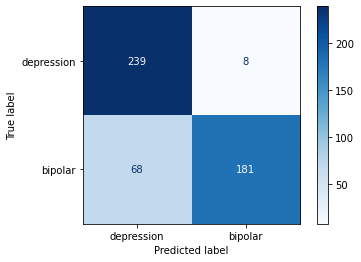

In [254]:
# View confusion matrix
plot_confusion_matrix(rf, X_test_cvec_rf, y_test, cmap='Blues', values_format='d', display_labels=['depression', 'bipolar']);

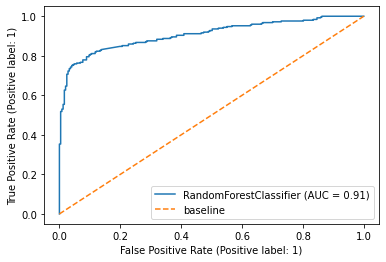

In [255]:
plot_roc_curve(rf, X_test_cvec_rf, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

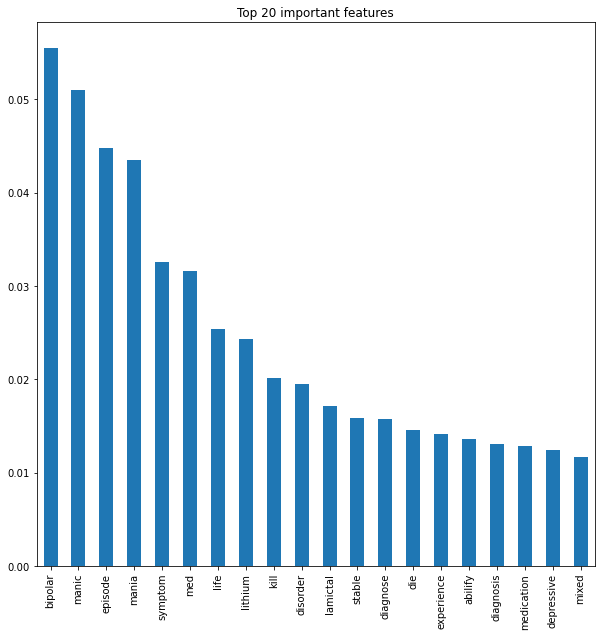

In [256]:
# Display the most important words to predict the correct results.
feat_importances = pd.Series(rf.feature_importances_, index=X_train_cvec_rf.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()

In [261]:
# Create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': rf.predict_proba(X_test_cvec_rf)[:,1]})
pred_df.head(10)

,true_values,pred_probs
74,1,0.431893
469,0,0.487663
142,1,0.585478
116,1,0.549965
696,0,0.471369
753,1,0.471711
730,1,0.487643
28,1,0.614855
292,0,0.435753
131,1,0.515763


In [279]:
# Check class distribution in test set
y_test.value_counts(normalize=True)

1    0.502016
0    0.497984
Name: subreddit, dtype: float64

We can see that our model accuracy score is 0.8468 but null accuracy score of the most frequent class is 0.5020. So, we can conclude that our Random Forest Classification model is doing a fairly job in predicting the class labels. As the ROC AUC of our model approaches towards 1, we can conclude that our classifier is fairly in predicting whether a post comes from depression or bipolar subreddit.

### `Multinomial Naive Bayes with CountVectorizer`

As this model is slightly underfit, we will increase the max_features to 1100.

In [140]:
cvec_nb = CountVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=3, max_features=1100)
X_train_cvec_nb = cvec_nb.fit_transform(X_train)
# Convert training data to dataframe
X_train_cvec_nb = pd.DataFrame(X_train_cvec_nb.toarray(),
                            columns=cvec_nb.get_feature_names())
X_test_cvec_nb = cvec_nb.transform(X_test)
# Convert test data to dataframe
X_test_cvec_nb = pd.DataFrame(X_test_cvec_nb.toarray(),
                           columns=cvec_nb.get_feature_names())
print('CountVectorizer:')
print(X_train_cvec_nb.sum().sort_values(ascending=False)[:5])
print()

CountVectorizer:
feel    1844
like    1717
get     1487
go      1145
want    1070
dtype: int64



In [143]:
nb = MultinomialNB()
nb.fit(X_train_cvec_nb, y_train)
y_pred = nb.predict(X_test_cvec_nb)
# Score model on training data
train_score = nb.score(X_train_cvec_nb, y_train)
# Score model on testing data
test_score  = nb.score(X_test_cvec_nb, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate accuracy
accu = round(accuracy_score(y_test,y_pred)*100,2)
# Calculate the sensitivity/ recall
sensitivity = tp / (tp + fn)
# Calculate the precision
precision = tp / (tp + fp)
# Calculate the f1 score
f1 = 2 * (sensitivity * precision)/ (sensitivity + precision)
roc_auc_train = roc_auc_score(y_train, nb.predict_proba(X_train_cvec_nb)[:,1])
roc_auc_test = roc_auc_score(y_test, nb.predict_proba(X_test_cvec_nb)[:,1])

# Print results
print(f'Train score: {round(train_score, 4)}')
print(f'Test score: {round(test_score,4)}')
print(f'Generalisation: {round(abs(100*(train_score - test_score) / train_score),2)}%')
print(f'Accuracy: {round(accu,4)}%')
print(f'Sensitivity: {tp / (tp + fn)}')
print(f'Specificity: {tn / (tn + fp)}')
print(f'Precision: {tp / (tp + fp)}')
print(f'F1-score: {round(f1,4)}')
print(f'Train ROC AUC score: {round(roc_auc_train,4)}')
print(f'Test ROC AUC score: {round(roc_auc_test,4)}')

Train score: 0.8539
Test score: 0.8528
Generalisation: 0.12%
Accuracy: 85.28%
Sensitivity: 0.8273092369477911
Specificity: 0.8785425101214575
Precision: 0.8728813559322034
F1-score: 0.8495
Train ROC AUC score: 0.9242
Test ROC AUC score: 0.9095


In [144]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn)
print(tp)
print(fn)
print(fp)

217
206
43
30


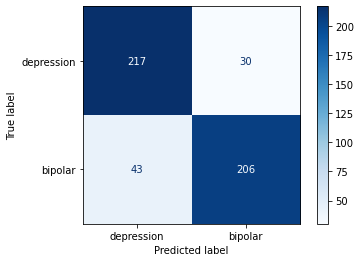

In [145]:
# View confusion matrix
plot_confusion_matrix(nb, X_test_cvec_nb, y_test, cmap='Blues', values_format='d', display_labels=['depression', 'bipolar']);

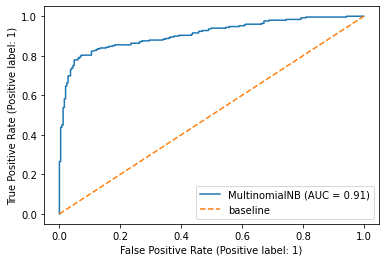

In [146]:
plot_roc_curve(nb, X_test_cvec_nb, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

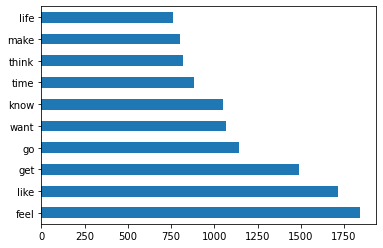

In [147]:
# Plot top occuring words
X_train_cvec_nb.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [275]:
# Create a dataframe called pred_df that contains:
# 1. The true values of our test set.
# 2. The predicted probabilities based on our model.
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': nb.predict_proba(X_test_cvec_nb)[:,1]})
pred_df.head(10)

,true_values,pred_probs
74,1,1.892913e-05
469,0,9.991035e-01
142,1,9.999811e-01
116,1,9.990990e-01
696,0,1.092946e-01
753,1,8.029742e-02
730,1,9.695326e-01
28,1,1.000000e+00
292,0,2.699085e-09
131,1,9.995502e-01


In [264]:
# Check class distribution in test set
y_test.value_counts(normalize=True)

1    0.502016
0    0.497984
Name: subreddit, dtype: float64

We can see that our model accuracy score is 0.8528 but null accuracy score of the most frequent class is 0.5020. So, we can conclude that our Multinomial Bayes Classification model is doing a fairly good job in predicting the class labels. As the ROC AUC of our model approaches towards 1, our classifier is fairly good in predicting whether a post comes from depression or bipolar subreddit.

Overall, both Random Forest and Multinomial Naive Bayes are doing well in terms of Accuracy and Test ROC AUC scores. However, Multinomial Naive Bayes will be chosen as my final model as it is slightly better in terms of performance than Random Forest and it's runtime is also much faster.

## Results Analysis and Conclusion

Both classifers tend to have the optimal hyperparameters setting and there are little performance gain from further tuning. The table below shows the various metrics scores of both the classifiers. 

We can see that both models' training-set and test-set accuracy score is quite close, and as they are quite comparable, there is very slight sign of overfitting. The generalisation score for Multinomial Naive Bayes classifier is however slightly better than Random Forest.

The accuracies of Random Forest and Multinomial Naive Bayes classifier is 84.68% and 85.28% respectively. This show Naive Bayes classifier can be used as the final model for classification with more accuracy.

ROC AUC of both the models is relatively close and approaches towards 1. Multinomial Naive Bayes, performs slightly better at predicting True Positive with Sensitivity score of 0.8273 and F1-score of 0.8495.


|Classifier|Train Score|Test Score|Generalisation|F1-score|Train ROC AUC|Test ROC AUC|
|----------|-----------|----------|--------------|--------|-------------|------------|
|Random Forest|0.8532|0.8468|0.75%|0.8265|0.9276|0.9073|
|Multinomial Naive Bayes|0.8539|0.8528|0.12%|0.8495|0.9242|0.9095|


|Classifier|Accuracy|Sensitivity|Specificity|Precision|
|----------|--------|-----------|-----------|---------|
|Random Forest|0.8468|0.7269|0.9676|0.9577|
|Multinomial Naive Bayes|0.8528|0.8273|0.8785|0.8729|

Conclusion and Recommendations

Using a Multinomial Naive Bayes classifier trained on title and selftext combined, I was able to predict post into r/depression or r/Bipolarreddit with a reasonable accuracy of ~85% - showing that although depression and bipolar have many similarities, they still have some key differences. The differences may mainly be due to differences in the behavior of depression and bipolar person. The similarities behind the model misclassifications may be due to more generic, day-to-day topics such as people asking for help or life advice, which are likely to be similar between the two subreddits.

To further improve model accuracy, a bigger corpus that incorporates a bigger vocabulary on the topic on depression and bipolar is needed. As society is constantly changing, new words are also constantly emerging in these subreddits. Therefore, it would not be enough to train the model on/obtain the training corpus from past subreddit posts. A more useful corpus for model training would be sites that report on both depression and bipolar conditions.

Areas for expansion and future exploration:

- use word similarities (e.g. word2vec) to classify posts instead of frequency
- use latent dirichlet allocation (LDA) to first extract topics from words before classifying (as a dimension reduction technique)
- explore other classification models e.g. SVM
- explore relationship between post content, number of comments, and upvote ratio